In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import psycopg2

pd.options.display.max_columns = 40

## Hack for Heat #5: How long do complaints take to resolve?

In this post, we're going to see if we can graph how long it takes for complaints to get resolved.

In [2]:
connection = psycopg2.connect('dbname= threeoneone user=threeoneoneadmin password=threeoneoneadmin')
cursor = connection.cursor()

cursor.execute('''SELECT createddate, closeddate, borough FROM service;''')
data = cursor.fetchall()
data = pd.DataFrame(data)

In [3]:
data.columns = ['createddate','closeddate','borough']

In [4]:
data = data.loc[data['createddate'].notnull()]
data = data.loc[data['closeddate'].notnull()]

In [5]:
data['timedelta'] = data['closeddate'] - data['createddate']

In [6]:
data['timedeltaint'] = [x.days for x in data['timedelta']]

In [7]:
data.head()

,createddate,closeddate,borough,timedelta,timedeltaint
0,2013-04-26,2013-04-26,QUEENS,0 days,0
1,2013-04-26,2013-04-29,MANHATTAN,3 days,3
2,2013-04-26,2013-04-30,MANHATTAN,4 days,4
3,2013-04-26,2013-04-26,QUEENS,0 days,0
4,2013-04-26,2013-04-30,STATEN ISLAND,4 days,4


In [8]:
data.groupby(by='borough')['timedeltaint'].mean()

borough
BRONX            -3.658691
BROOKLYN         -6.835417
MANHATTAN       -20.325506
QUEENS           -4.121806
STATEN ISLAND    -2.108396
Unspecified       4.699638
Name: timedeltaint, dtype: float64

Oops! Looks like something's wrong. Let's try and find out:

In [9]:
data.sort_values('timedeltaint').head()

,createddate,closeddate,borough,timedelta,timedeltaint
604564,2016-03-16,1900-01-01,Unspecified,-42443 days,-42443
596082,2016-03-16,1900-01-01,Unspecified,-42443 days,-42443
605654,2016-03-16,1900-01-01,QUEENS,-42443 days,-42443
606458,2016-03-15,1900-01-01,MANHATTAN,-42442 days,-42442
552013,2016-03-14,1900-01-01,Unspecified,-42441 days,-42441


In [10]:
data.sort_values('timedeltaint', ascending=False).head()

,createddate,closeddate,borough,timedelta,timedeltaint
9392808,2010-04-08,2201-05-13,BRONX,69796 days,69796
9525584,2010-06-01,2201-06-17,BROOKLYN,69777 days,69777
1581464,2011-01-20,2201-03-25,BRONX,69460 days,69460
1536326,2015-11-03,2100-01-01,QUEENS,30740 days,30740
2479091,2013-01-10,2023-05-01,BROOKLYN,3763 days,3763


Ah. Well, as a first step, let's remove any values that are before Jan 1st 2010 or after today:

In [11]:
import datetime

today = datetime.date(2016,5,29)
janone = datetime.date(2010,1,1)

Let's also remove any rows where the close date is before the created date:

In [12]:
subdata = data.loc[(data['closeddate'] > janone) & (data['closeddate'] < today)]
subdata = subdata.loc[data['closeddate'] > data['createddate']]

In [13]:
len(subdata)

7979757

In [14]:
subdata.sort_values('timedeltaint').head()

,createddate,closeddate,borough,timedelta,timedeltaint
11371297,2015-08-28,2015-08-29,QUEENS,1 days,1
7950080,2015-06-20,2015-06-21,BROOKLYN,1 days,1
2366882,2012-11-19,2012-11-20,MANHATTAN,1 days,1
2366879,2015-06-09,2015-06-10,Unspecified,1 days,1
2366874,2012-04-17,2012-04-18,BROOKLYN,1 days,1


In [15]:
subdata.sort_values('timedeltaint',ascending = False).head()

,createddate,closeddate,borough,timedelta,timedeltaint
10774084,2010-01-06,2016-03-24,BROOKLYN,2269 days,2269
1506622,2010-02-19,2016-05-02,BROOKLYN,2264 days,2264
1508205,2010-03-02,2016-05-04,STATEN ISLAND,2255 days,2255
513580,2010-01-01,2016-02-17,STATEN ISLAND,2238 days,2238
589865,2010-01-22,2016-02-25,BRONX,2225 days,2225


This looks a little bit more realistic, but let's also visualize the distribution:

In [16]:
plotdata = list(subdata['timedeltaint'])

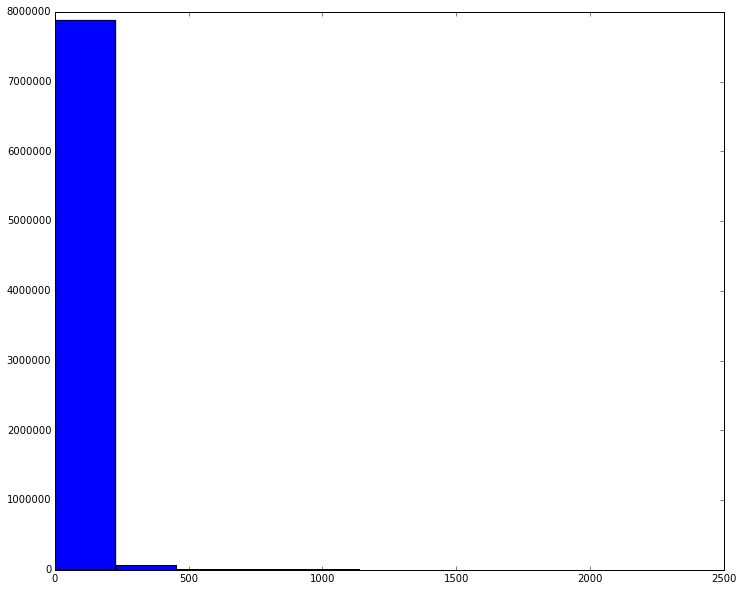

In [17]:
plt.figure(figsize=(12,10))
plt.hist(plotdata);

Okay, this still looks really wonky. Let's further subset the data, and see what happens when we remove the top and bottom 2.5%.

Pandas has a quantile function:

In [18]:
subdata.quantile([.025, .975])

,timedeltaint
0.025,1
0.975,138


In [19]:
quantcutdata = subdata.loc[(subdata['timedeltaint'] > 1) & (subdata['timedeltaint'] < 138) ]

In [20]:
len(quantcutdata)

6278707

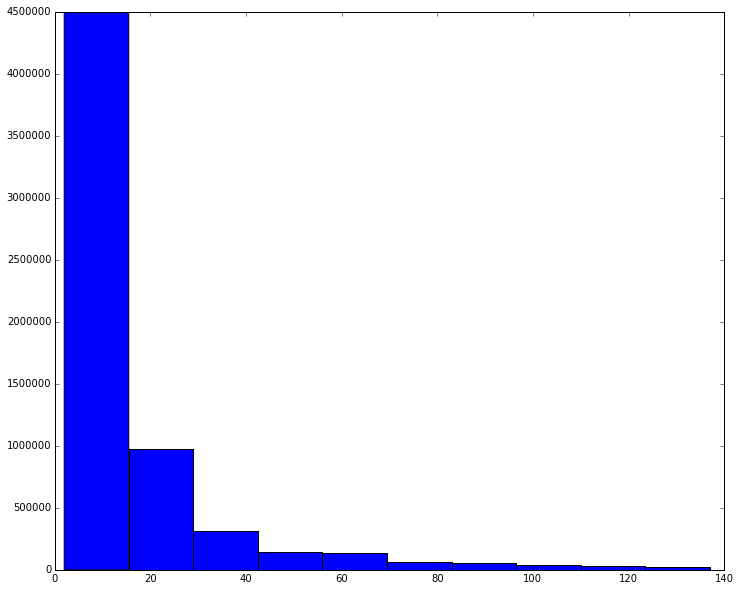

In [21]:
plotdata = list(quantcutdata['timedeltaint'])

plt.figure(figsize=(12,10))
plt.hist(plotdata);

That looks a little better, but there might be other ways to filter out bad data.

In [22]:
subdata.groupby(by='borough').median()

,timedeltaint
borough,
BRONX,5
BROOKLYN,5
MANHATTAN,6
QUEENS,5
STATEN ISLAND,4
Unspecified,5


In [23]:
subdata.groupby(by='borough').mean()

,timedeltaint
borough,
BRONX,18.789025
BROOKLYN,20.725656
MANHATTAN,20.841213
QUEENS,23.746771
STATEN ISLAND,26.283222
Unspecified,11.652647


So, I definitely wouldn't trust these data right now - I'm still working on finding a data dictionary for the 311 data, and I need to make sure the columns mean what I think they mean. The point of this is just to show that the process would be once I get my hands on reliable data.